# HR Diagram of M5 Cluster
by Michael Chenevey

## TODO:
- ~~Flat, bias all images~~
- Redo Workshop 4
- Abstract mag to a function
- Find easy way to box a bunch of stars
- Box and mag each star in each filter, calculate temp for each
- Graph HR Diagram for collected stars

## Photometry
We use the astropy package to handle to fits images and as a helper with statistics

In [32]:
# Import astropy packages
import astropy.stats as astats
from astropy.io import fits
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 10,8
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.size'] = 12

from astropy.stats import sigma_clipped_stats
from photutils import find_peaks
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture

from photutils import aperture_photometry, CircularAperture
from astropy.modeling import models, fitting

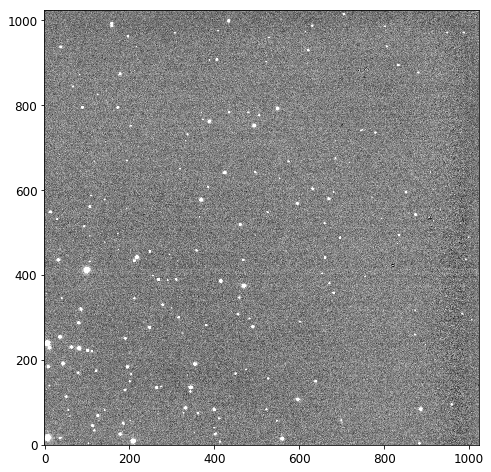

x_peak y_peak peak_value
------ ------ ----------
   104      4  185.49638
   884      4  511.35223
   413      7  289.21841
   210      9  8671.1719
   560     15   2381.678
     8     17  26105.938
    38     17  680.23651
   179     25   1582.504
   403     26  1072.6155
   353     28  186.25732


In [29]:
# Open an image
filename = 'fbt_0137.M67.fits'
hdulist  = fits.open(filename)
imlist  = hdulist[1:]

scidata = imlist[0].data

# Calculate the mean, median, and standard deviation of the data in the image.
mean, median, std = astats.sigma_clipped_stats(scidata, sigma=3.0, maxiters=5)

# Plot the image
plt.figure(figsize=(10,8)) 
plt.imshow(scidata, vmin=median-6.0*std, vmax=median+6.0*std, cmap='gray', origin='lower')
plt.show()

mean, median, std = sigma_clipped_stats(scidata, sigma=3.0)
threshold = median + (5. * std)
tbl = find_peaks(scidata, threshold, box_size=11)
tbl['peak_value'].info.format = '%.8g'  # for consistent table output
print(tbl[:10])    # print only the first 10 peaks

(0, 1023)

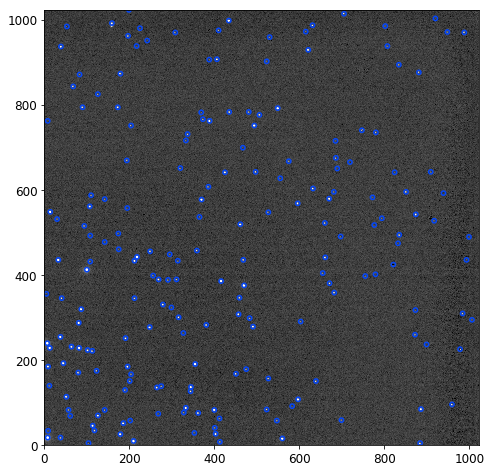

In [30]:
positions = (tbl['x_peak'], tbl['y_peak'])

def get_rect(x, y):
    return (max(0, x - 10), max(0, y - 10), x + 10, y + 10)

rects = [get_rect(positions[0][i], positions[1][i]) for i in range(len(positions[0]))]
apertures = CircularAperture(positions, r=5.)
norm = simple_norm(scidata, 'sqrt', percent=99.9)
plt.imshow(scidata, cmap='Greys_r', origin='lower', norm=norm)
apertures.plot(color='#0547f9', lw=1.5)
plt.xlim(0, scidata.shape[1]-1)
plt.ylim(0, scidata.shape[0]-1)

We can do a test on one of our stars now:

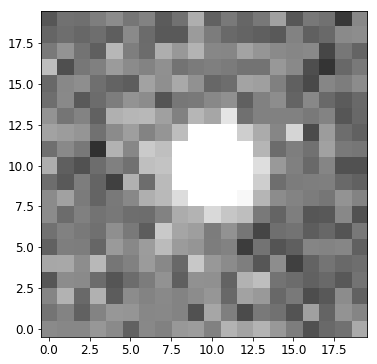

In [31]:
rect = rects[31]

# Crop the Array
cropped_data = scidata[rect[1]:rect[3],rect[0]:rect[2]]

# Plot the Data
plt.figure(figsize=(6,6)) 
plt.imshow(cropped_data, vmin=median-6.0*std, vmax=median+6.0*std, cmap='gray', origin='lower')
plt.show()

From Workshop 4:

"Stars on an image have what is called a Point Spread Function, which is, simply put, a function of how the photons spread over the image. A gaussian is a reasonable function that describes a star's PSF. Now, just like we fit a gaussian function before to the spectroscopic line, we're going to fit a 2D gaussian to the star.

In this case you don't have to define a 2D gaussian, one is already provided for you in the astropy package. We're going to import this model as well as a function that can fit these models. Since the image also has a background, we are going to need a compound model that combined a 2D Gaussian plus a constant background.

Based on the image above, we can fill in the missing parameters for initial guess for the model."

In [33]:
# Construct the Model
starmodel = models.Gaussian2D(amplitude=10000.0, x_mean=10.0, y_mean=10.0, x_stddev=1.0, y_stddev=1.0)
const     = models.Const2D(amplitude=20000.0)
fullmodel = starmodel + const

# We need a grid over which to fit the model
y, x = np.mgrid[:20, :20]

# Fit the data
fitter = fitting.LevMarLSQFitter()

# Print Results
bestfit = fitter(fullmodel, x, y, cropped_data)
print("A = "       + str(bestfit.amplitude_0.value))
print("x = "       + str(bestfit.x_mean_0.value   ))
print("y = "       + str(bestfit.y_mean_0.value   ))
print("x_sigma = " + str(bestfit.x_stddev_0.value ))
print("y_sigma = " + str(bestfit.y_stddev_0.value ))
print("C = "       + str(bestfit.amplitude_1.value ))

A = 613.3860351459256
x = 9.98317341699148
y = 10.117282412889429
x_sigma = 0.9963959585775348
y_sigma = 1.0457527774645217
C = 118.58893422000008


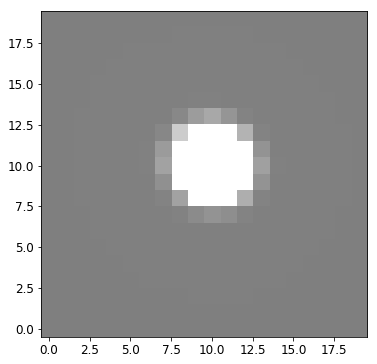

In [44]:
# Evaluate the best model
resulting_model = bestfit(x,y)

# Get the median
_, median_model, _ = astats.sigma_clipped_stats(resulting_model, sigma=3.0, maxiters=5)

plt.figure(figsize=(6,6))
plt.imshow(bestfit(x,y), vmin=median_model-6.0*std, vmax=median_model+6.0*std, cmap='gray', interpolation='none', origin='lower')
plt.show()

(949, 85, 969, 105)
958.9831734169915 95.11728241288942 6.0111159732080655


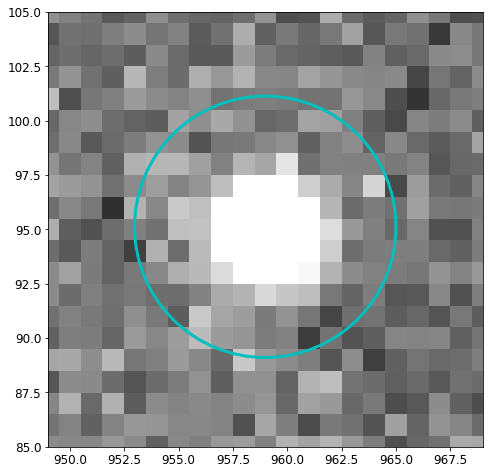

 id      xcenter           ycenter         aperture_sum   
           pix               pix                          
--- ----------------- ----------------- ------------------
  1 958.9831734169915 95.11728241288942 17861.616913298312


In [47]:
sigma = (bestfit.x_stddev_0.value + bestfit.y_stddev_0.value) / 2
FWHM = (2 * (2 * np.log(2)) ** (1/2)) * sigma
scale = 0.774
seeing = FWHM * scale

print(rect)
xcenter       = rect[0] + bestfit.x_mean_0.value
ycenter       = rect[1] + bestfit.y_mean_0.value
aperture_size = 2.5 * FWHM
print(xcenter, ycenter, aperture_size)

# Define an Aperture
position = (xcenter, ycenter)
aperture = CircularAperture(position, r=aperture_size)

# Plot the aperture
plt.figure(figsize=(8,8))
plt.imshow(scidata, vmin=median_model-6.0*std, vmax=median_model+6.0*std, cmap='gray', interpolation='none')
aperture.plot(color='c', lw=3)

#zoom in on region where star is 
plt.xlim(rect[0],rect[2])
plt.ylim(rect[1],rect[3])
plt.show()

result = aperture_photometry(scidata, aperture)
print(result)

### Again, from Workshop 4: ###

Now that we know how many counts there are in the aperture, we can figure out the magnitude of the star.

We can use the documentation of IRAF's `phot` function to figure out how to calculate this. `phot` calculates the magnitude as follows:

$$ flux = sum - area \times msky $$
$$ mag = zmag - 2.5 \times \log(flux) + 2.5 \times \log(itime) $$
$$ error = sqrt\left(\frac{flux}{epadu} + area \times stdev^2 + area^2 \times \frac{stdev^2}{nsky}\right) $$
$$ merr = 1.0857 \times \left(\frac{error}{flux}\right) $$

In these equations, $sum$ is the number of counts inside the aperture, $msky$ is the number of counts per pixel due to the sky, $area$ is the number of pixels in the aperture, $zmag$ is the zero-point (30 is the default), $itime$ is the exposure time, $epadu$ is the gain in electrons per adu, $stdev$ is the standard deviation of the background in counts, and $nsky$ is the number of pixels used for the sky region. 1.0857 is the correction term between an error in flux (electons) and one in magnitudes.

In [ ]:
flux = result['aperture_sum'] - np.pi * msky